# Bank Customer Churn Prediction
## EDA

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot') #'fivethirtyeight')
import seaborn as sns

import numpy as np
import pandas as pd

import scipy.stats as scs
import scipy

import itertools

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline


In [44]:
# read in the data
df = pd.read_csv('../data/bank_churn.csv', ';')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [46]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [47]:
df.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

In [48]:
# We can drop the 'customer_id', as it carries no signal
df = df.drop(['customer_id'], axis=1)

In [49]:
# Describe
df.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


The data is clean!

Countries:  ['France' 'Spain' 'Germany']


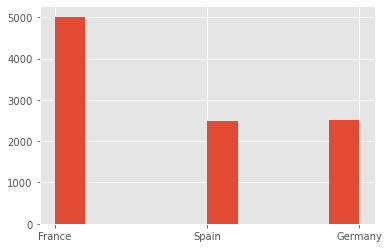

In [50]:
# Countries - see if it is imbalanced
print('Countries: ', df['country'].unique())
df['country'].hist();

The data is Spain and Germany are each a quarter of the entire data with France having the other half. This should not be a problem.

Genders:  ['Female' 'Male']


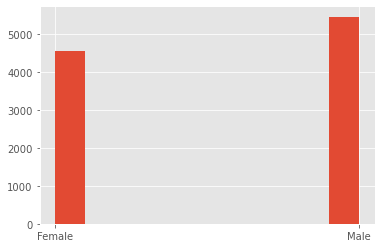

In [51]:
# Genders - check if it is imbalanced
print('Genders: ', df['gender'].unique())
df['gender'].hist();

Evenly balanced male vs. female data

In [52]:
# We can change 'gender' to 0 for female and 1 for male
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

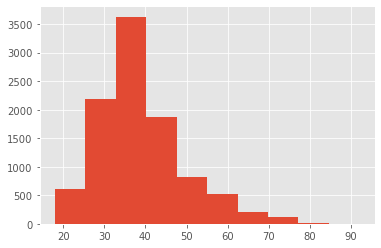

In [53]:
# Ages - check distribution
df['age'].hist();

Normally distributed age data with slight right skew

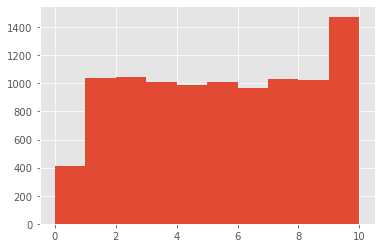

In [54]:
# Tenures - check distribution
df['tenure'].hist();

Uniform distribution of tenure data from 1 to 9 years. Under-represented new customers, over-represented 10-year customers.

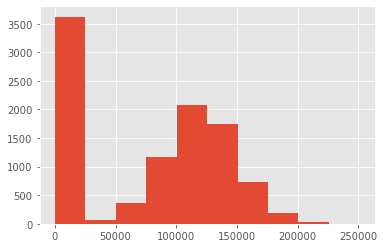

In [55]:
# Balance - check distribution
df['balance'].hist();

Normally distributed, except for the anomaly at the lower end (zero balance) - are these new customers?

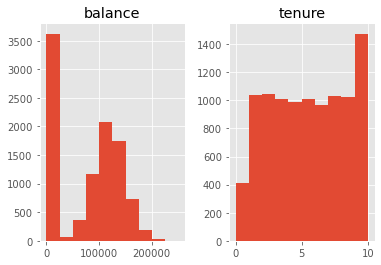

In [56]:
df[['balance', 'tenure']].hist();

There does not appear to be a relationship between very low balance and tenure. 

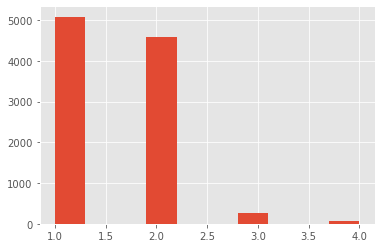

In [57]:
# Number of products used - check distribution
df['products_number'].hist();

About the same # of customers having 1 and 2 products, very few with 3 or 4 products.

Credit cards:  [1 0]


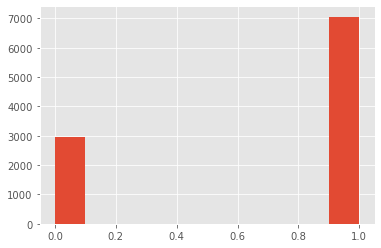

In [58]:
# Credit Card - confirm that is categorical (and NOT a count of credit cards a customer holds), check distribution
print('Credit cards: ', df['credit_card'].unique())
df['credit_card'].hist();

Slightly less than half the customers do not have credit cards. Should not be a problem.

Active Member:  [1 0]


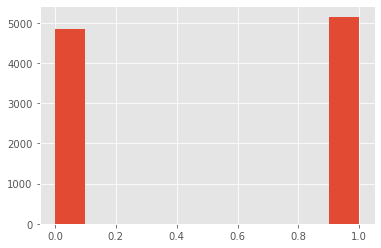

In [59]:
# Active Member - confirm that this is categorical, check distribution
print('Active Member: ', df['active_member'].unique())
df['active_member'].hist();

df['active'] is a categorical feature and is evenly distributed between active and non-active members

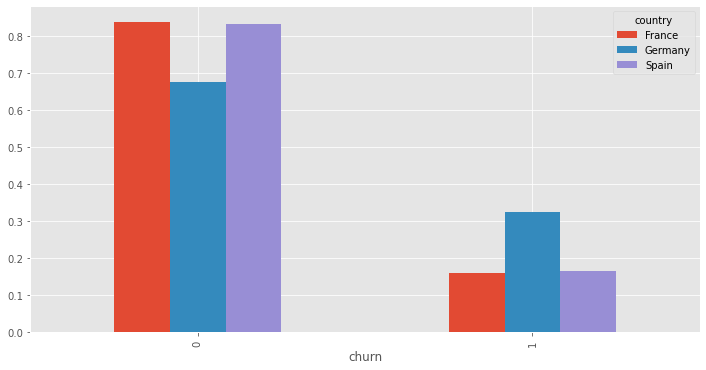

In [60]:
# Percent of customers who churned from each country
churned = pd.crosstab(df['churn'], df['country'], rownames=['churn'])
(churned / churned.apply(sum)).plot(kind="bar", figsize=(12, 6));

In [61]:
# Is the distribution of churn unbalanced?
df['churn'].value_counts() / len(df)

0    0.7963
1    0.2037
Name: churn, dtype: float64

Churn is about the same in France and Spain, but more in Germany. 

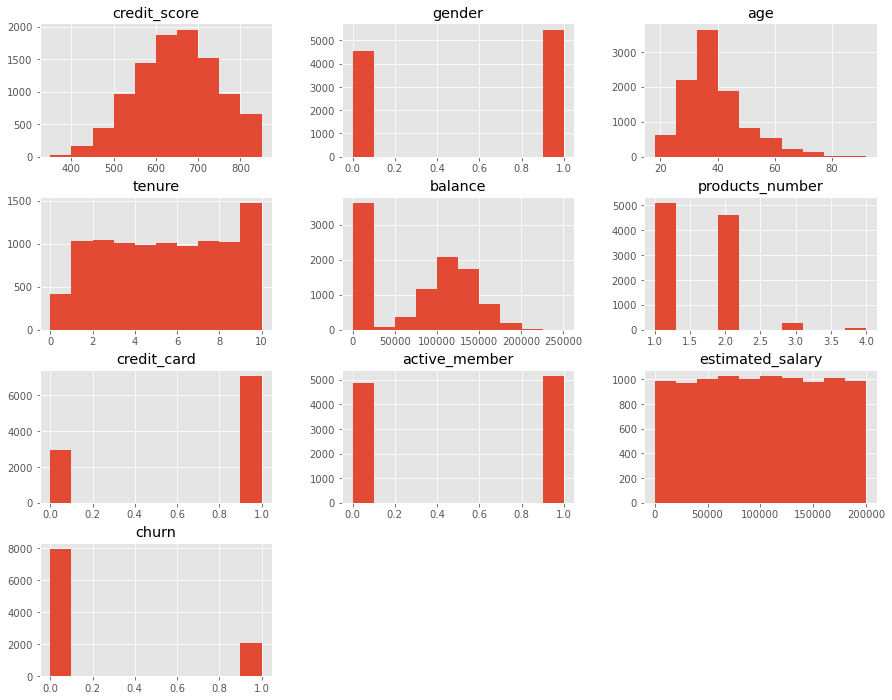

In [62]:
# Sanity check
df.hist(figsize=(15, 12));

All distributions are not too unbalanced and so should be OK


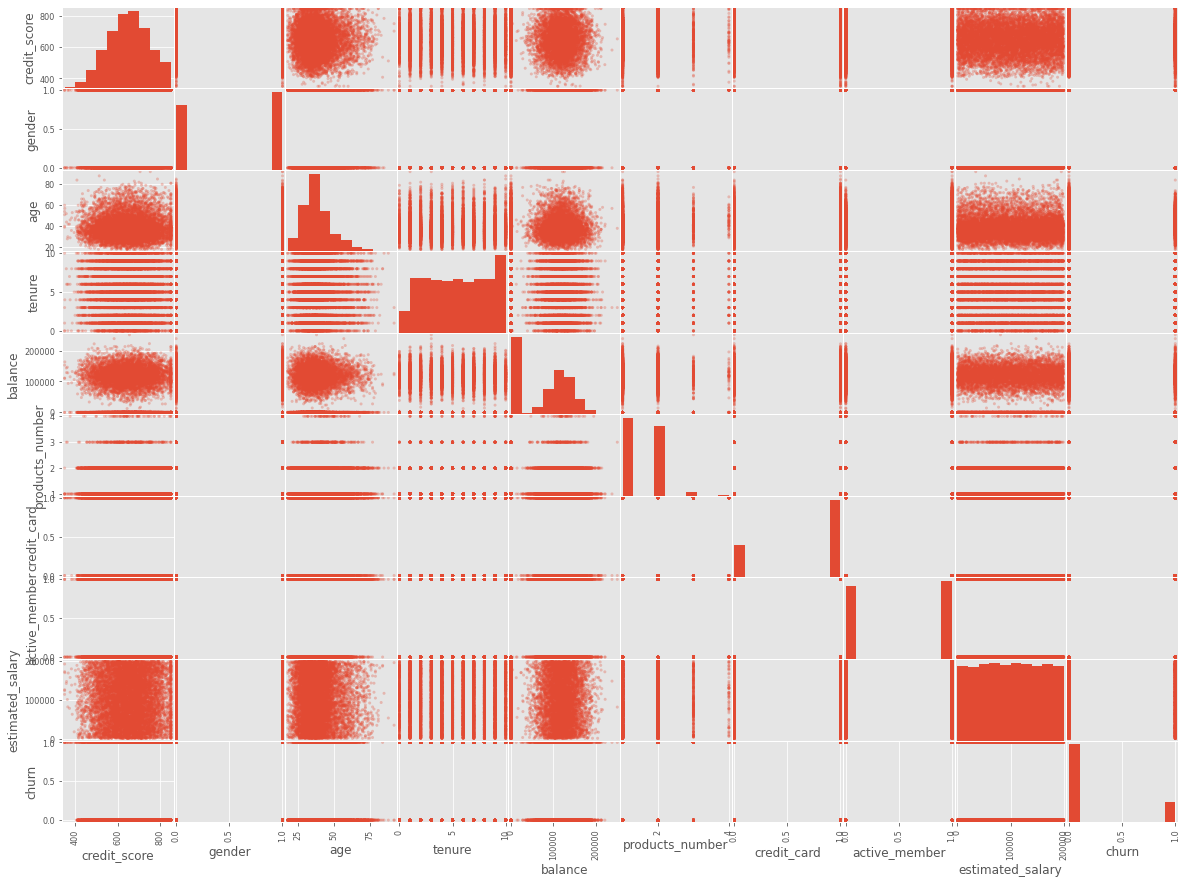

In [63]:
# Plot a scatter matrix of all features
pd.plotting.scatter_matrix(df, figsize=(20, 15), alpha=0.3);

There does not appear to be any obvious correlations between any single feature and churn

Let's look again at overall churn and churn by 'country' feature, we know that Germany has the worst churn

In [64]:
# 1 = Churn, 0 = Not Churn
print('Overall Churn = ', df['churn'].mean())

Overall Churn =  0.2037


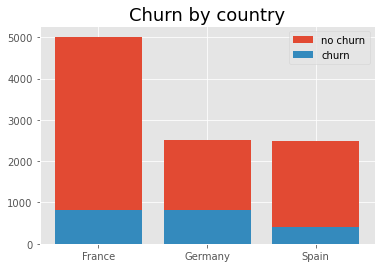

In [65]:
churn_by_country = df.groupby('country')['churn'].count()
num_churn_by_country = df.groupby('country')['churn'].sum()
plt.bar(churn_by_country.index, churn_by_country.values, label='no churn')
plt.bar(num_churn_by_country.index, num_churn_by_country.values, label='churn')
plt.title('Churn by country', fontsize=18)
plt.legend();

#### Explore some intuitive questions

Do customers that churn have lower credit scores?

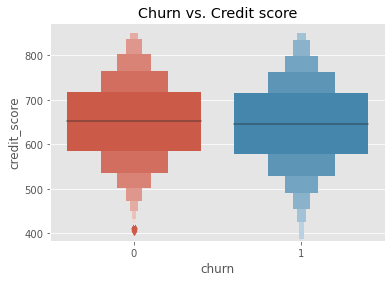

In [66]:
sns.boxenplot(df['churn'], df['credit_score'])
plt.title('Churn vs. Credit score')
plt.savefig('../Images/Churn_vs_CreditScore.png')

Apparently not. Customers that churn have the same credit score distribution as those that don't churn.

Do customers with a lower balance churn more?

In [67]:
# dummies = pd.get_dummies(df['country'], prefix='country')
# X2 = df[['gre','gpa']].join(dummies.loc[:,'rank_2':]).values
# X2

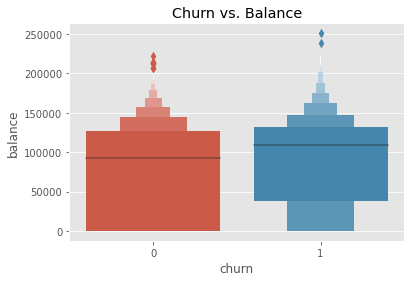

In [68]:
sns.boxenplot(df['churn'], df['balance'])
plt.title('Churn vs. Balance')
plt.savefig('../Images/Churn_vs_Balance.png')

Again, no big difference.

Do customers with a lower tenure or higher tenure tend to churn more?

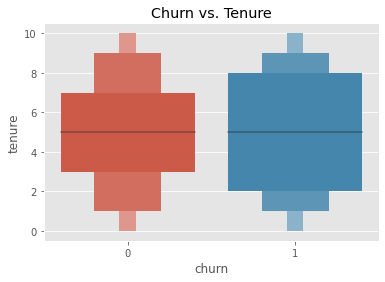

In [69]:
sns.boxenplot(df['churn'], df['tenure'])
plt.title('Churn vs. Tenure')
plt.savefig('../Images/Churn_vs_Tenure.png')

Again, similar distributions are observed.

Try salary vs. churn

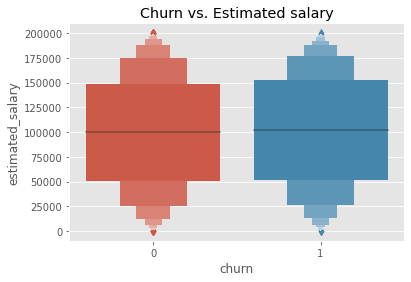

In [70]:
sns.boxenplot(df['churn'], df['estimated_salary'])
plt.title('Churn vs. Estimated salary')
plt.savefig('../Images/Churn_vs_Estimated_salary.png')

Identical distributions, no clues here!

Does churn have any correlation to age?

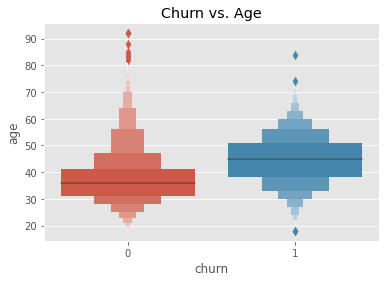

In [71]:
sns.boxenplot(df['churn'], df['age'])
plt.title('Churn vs. Age')
plt.savefig('../Images/Churn_vs_Age.png')

Churners tend to be older!

Does gender matter?

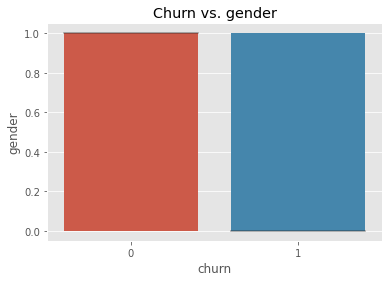

In [72]:
sns.boxenplot(df['churn'], df['gender'])
plt.title('Churn vs. gender')
plt.savefig('../Images/Churn_vs_Gender.png')

No, not at all.

Does having a credit card vs churn look interesting?

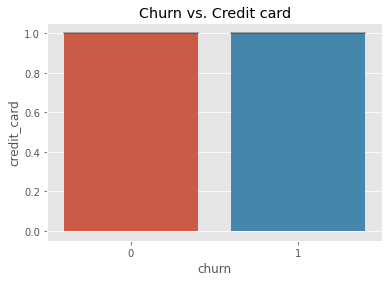

In [73]:
sns.boxenplot(df['churn'], df['credit_card'])
plt.title('Churn vs. Credit card')
plt.savefig('../Images/Churn_vs_Credit_card.png')

Nope.

How about whether the customer is active or not?

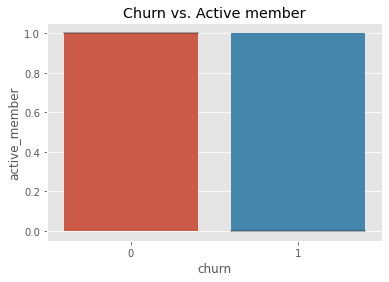

In [74]:
sns.boxenplot(df['churn'], df['active_member'])
plt.title('Churn vs. Active member')
plt.savefig('../Images/Churn_vs_Active_member.png')

Churn appears identical for both active and non-active members

Finally, let's check the distribution of number of products a customer uses against churn

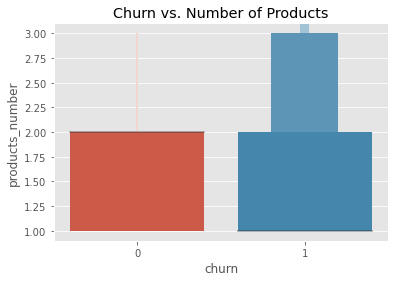

In [75]:
sns.boxenplot(df['churn'], df['products_number'])
plt.title('Churn vs. Number of Products')
plt.savefig('../Images/Churn_vs_Products_number.png')

Customers using more products churn more!

Other than 'country' and 'products_number, all the other predictors appear to have little obvious impact on churn. We shall have to let the ML models do their job!

But first, deal with the 'country' categorical feature - use get_dummies

In [76]:
# Encode the category 'country'
X = pd.get_dummies(df)

In [119]:
# Take the label out of X and into y, take out the redundant feature 'country_Spain' from X
Full_y = X['churn']
Full_X = X.drop(['country_Spain', 'churn'], axis=1)
print(f'Full X shape: {Full_X.shape}')
print(f'Full y shape: {Full_y.shape}')

Full X shape: (10000, 11)
Full y shape: (10000,)


### Split the data

In [120]:
X_train, X_final_test, y_train, y_final_test \
    = train_test_split(Full_X, Full_y, test_size=0.10, train_size=0.90, random_state=13)

In [121]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_final_test shape: {X_final_test.shape}')
print(f'y_final test shape: {y_final_test.shape}')

X_train shape: (9000, 11)
y_train shape: (9000,)
X_final_test shape: (1000, 11)
y_final test shape: (1000,)


### Run the first 3 models: LogisticRegression, RandomForestClassifier, and GradientBoostingClassifier 

In [122]:
def run_models(estimator, X_train, y_train, stratified=False):

    if stratified:
        kf = StratifiedKFold(n_splits=5, shuffle=True)
    else:
        kf = KFold(n_splits=5, shuffle=True)
    
    accuracy = []
    precision = []
    recall = []
    for train_idx, test_idx in kf.split(X_train, y_train):

        # data prep
        
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]

        X_test_fold = X_train.iloc[test_idx]
        y_test_fold = y_train.iloc[test_idx]

        # fit model, predict, compute scores
        
        estimator.fit(X_train_fold, y_train_fold)
        y_preds_fold = estimator.predict(X_test_fold)
        accuracy.append(accuracy_score(y_test_fold, y_preds_fold))
        precision.append(precision_score(y_test_fold, y_preds_fold))
        recall.append(recall_score(y_test_fold, y_preds_fold))
        
    return (accuracy, precision, recall)

In [123]:
def plot_models(results):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for i, estimator in enumerate(estimators):
        axs[i].set_title(estimator.__class__.__name__, fontsize=20)
        axs[i].plot(range(1, 5+1), results[i][0], label='Accuracy', c='green')
        axs[i].plot(range(1, 5+1), results[i][1], label='Precision', c='red')
        axs[i].plot(range(1, 5+1), results[i][2], label='Recall', c='blue')
        axs[i].set_ylabel('Accuracy, Precision, Recall')
        axs[i].set_xlabel('Number of folds')
        axs[i].legend()


In [124]:
estimators = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]
results = []
for estimator in estimators:
    results.append((run_models(estimator, X_train, y_train)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


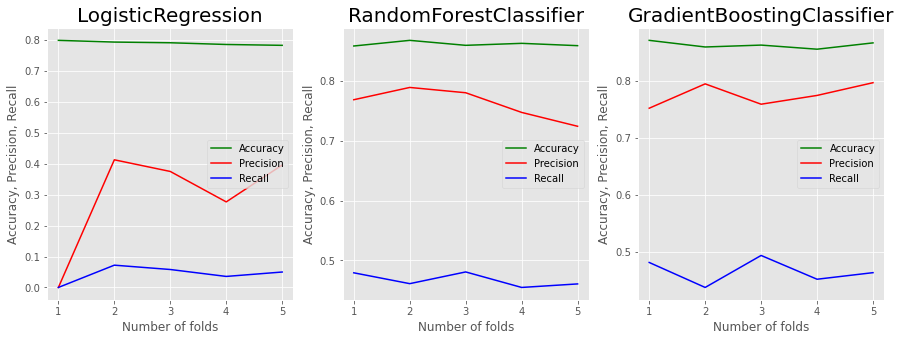

In [125]:
plot_models(results)

Accuracy, and Precision are reasonable, however, Recall is poor - but this the mteric we're most interested in because false negatives (not finding churners) is what we most want to minimize. Our poor Recall scores are likely because of the imbalance between our classes in the training data:

    No churn: 79.63%
    Churn:    20.37%
    
Rather than Accuracy, we should consider alternate measures, such as:

- Recall/Sensitivity: how many relevant instances are selected.

as well as:

- Precision/Specificity: how many selected instances are relevant.
- F1 score: harmonic mean of precision and recall.
- MCC: correlation coefficient between the observed and predicted binary classifications.
- AUC: relation between true-positive rate and false positive rate.

A few techniques to consider are:

- Undersampling the majority class: reducing the size of the abundant class in training data
- Oversampling the minority class: generating new rare samples using repetition, bootstrapping or SMOTE (Synthetic Minority Over-Sampling Technique)
- Ensemble different resampled datasets: Keep 1000 cases of the rare class and randomly sample 1000 cases of the abundant class in 8 chunks and train 8 different ensembled models.

But first, let's observe what StratifyKFold does: preserving the class  the samples during the KFold process to preserve the proportion of both classes, so that we don't see zero values for precision because there happen to be no samples of the minority class in any fold

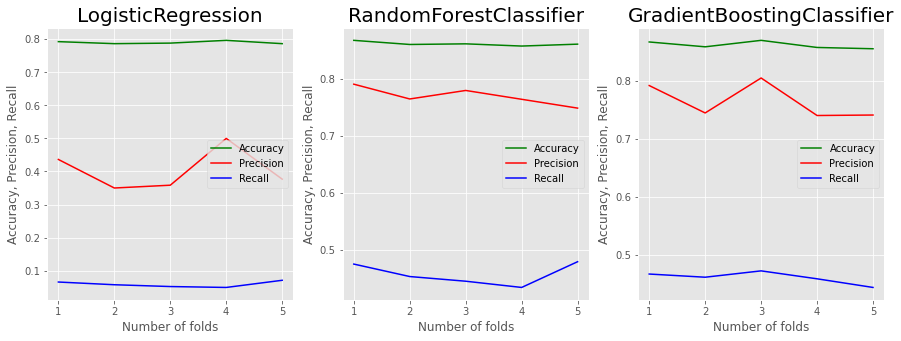

In [126]:
estimators = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]
results = []
for estimator in estimators:
    results.append((run_models(estimator, X_train, y_train, stratified=True)))
plot_models(results)

Maybe, slightly better Precision, no zero values (because no fold has zero samples of the minority class) - however, Recall is still poor.

### Under-sampling the majority class 

In [127]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

# count the minority class
print(y_train[y_train == 1].shape)

X_train shape: (9000, 11)
y_train shape: (9000,)
(1831,)


In [128]:
# First put X_train and y_train together
# pd.concat([dat1, dat2], axis=1) 
Xy_temp = pd.concat([X_train, y_train], axis=1)
Xy_temp.head(2)

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_France,country_Germany,churn
1257,628,0,38,3,0.00,2,1,1,48924.73,1,0,0
7396,603,0,56,5,90778.76,2,1,0,162223.67,0,0,1


In [129]:
# Now take all samples that are in the minority class then add an equal number of samples from the majority class
X_train_under_sampled = Xy_temp[Xy_temp['churn'] == 1] \
                        .append(Xy_temp[Xy_temp['churn'] == 0].sample(Xy_temp[Xy_temp['churn'] == 1].shape[0]))

In [130]:
# Now pull y_train_under_sampled out
y_train_under_sampled = X_train_under_sampled['churn']
X_train_under_sampled = X_train_under_sampled.drop(['churn'], axis=1)

In [131]:
print(X_train_under_sampled.shape)
print(y_train_under_sampled.shape)

(3662, 11)
(3662,)


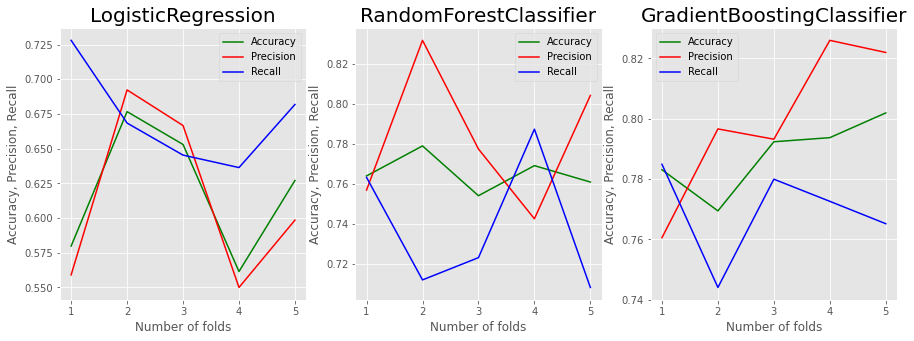

In [132]:
# Now see if the models do better with this under-sampled data
estimators = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]
results = []
for estimator in estimators:
    results.append((run_models(estimator, X_train_under_sampled, y_train_under_sampled, stratified=False)))
plot_models(results)

Much better!

### Over-sampling the minority class

### Some useful unix commands
From Tony Marquez to Everyone: 

wc -l

pip install --upgrade pandas

!head filename

head -n 100 filename > testfile.json